In [26]:
import torch
import numpy as np
import datasets
import pickle
import pathlib
import os
from importlib import reload
import sys
import pandas as pd
from IPython.display import display, HTML
import json
import sklearn
import scipy
import matplotlib.pyplot as plt
import matplotlib

from tqdm.auto import tqdm
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers.trainer_pt_utils import LengthGroupedSampler
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding
)

# For Imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# print("sys.path:", sys.path)
plt.style.use("ggplot")
plt.rcParams.update({'font.size': 16})

In [50]:
MODELS_DIR = "/home/modaresi/projects/globenc_analysis/outputs/models"
OUTPUT_DIR = "/home/modaresi/projects/globenc_analysis/outputs/globencs_v3"
ALTI_OUTPUT_DIR = "/home/modaresi/projects/globenc_analysis/outputs/ALTI"
IG_OUTPUT_DIR = "/home/modaresi/projects/globenc_analysis/outputs/integrated_saliencies"

MODEL_DATASET_SET = [
#     (f"{MODELS_DIR}/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-1340", "cola", "validation"),
    (OUTPUT_DIR, f"{MODELS_DIR}/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-10525", "sst2", "validation"),
#     (f"{MODELS_DIR}/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-575", "mrpc", "validation"),
#     (f"{MODELS_DIR}/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-16370", "qnli", "validation"),
#     (f"{MODELS_DIR}/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-61360", "mnli", "validation_matched"),
#     (f"{MODELS_DIR}/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-10525", "sst2", "validation"),
    (ALTI_OUTPUT_DIR, f"{MODELS_DIR}/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-10525", "sst2", "validation"),
    (IG_OUTPUT_DIR, f"{MODELS_DIR}/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-10525", "sst2", "validation"),
]

GLOBENC_CONFIG_NAMES = [
#     "Decomposition LinearApproximation", 
    "Decomposition AbsDot Bias", 
    "GlobEnc",
#     "GlobEnc FFN LinearApproximation",
#     "GlobEnc FFN ZeroOriginApproximation",
    "ALTI",
    "IG_ALL_ZERO_SUM_prediction_based",
    "IG_ALL_ZERO_NORM_prediction_based",
]

In [32]:
def print_importance(importance, tokenized_text, discrete=False, prefix="", no_cls_sep=False):
    """
    importance: (sent_len)
    """
    if no_cls_sep:
        importance = importance[1:-1]
        tokenized_text = tokenized_text[1:-1]
    importance = importance / importance.max()  # Normalize
    if discrete:
        importance = np.argsort(np.argsort(importance)) / len(importance)
    
    html = "<pre>"+prefix
    for i in range(len(tokenized_text)):
        rgba = matplotlib.cm.get_cmap('Wistia')(importance[i])   # Wistia
        color = f"background-color: rgba({rgba[0]*255}, {rgba[1]*255}, {rgba[2]*255}, {rgba[3]}); "
        html += (f"<span style='"
                 f"{color}"
                 f"font-weight: {int(800)};"
                 "'>")
        html += tokenized_text[i]
        html += "</span> "
    display(HTML(html))

In [34]:
# Read Globencs
# globencs = dict()
for dir_model_dataset_set in tqdm(MODEL_DATASET_SET, desc="Models_Dataset_Sets"):
    dir, model_checkpoint, task_name, set_of_data = dir_model_dataset_set
    for cfg_name in tqdm(GLOBENC_CONFIG_NAMES, desc="Configs"):
        file_name = f"[{task_name}]_[{set_of_data}]_[{'-'.join(model_checkpoint.split('/')[-2:])}]_[{cfg_name}]"
        
        try:
            df = pd.read_pickle(f"{dir}/{file_name}.pkl")
        except Exception as e:
            continue
        
        print(file_name)
        idx = 0
        for col in ["importance_last_layer_aggregated", "importance_last_layer_classifier", "importance_last_layer_pooler"]:
            if df[col][idx] is not None:
                if "aggregated" in col:
                    sentence_importance = df[col].iloc[idx][0, :]
                if "classifier" in col:
                    for label in range(df[col].iloc[idx].shape[-1]):
                        sentence_importance = df[col].iloc[idx][:, label]
                        print_importance(
                            sentence_importance,
                            df["tokens"].iloc[idx], 
                            prefix=f"{col.split('_')[-1]}L{label}|L={df['label'].iloc[idx]}:".ljust(20),
                            no_cls_sep=True,
                            discrete=False
                        )
                    break
                    sentence_importance = df[col].iloc[idx][:, df["label"].iloc[idx]]
                if "pooler" in col:
                    sentence_importance = df[col].iloc[idx]
                print_importance(
                    sentence_importance,
                    df["tokens"].iloc[idx], 
                    prefix=f"{col.split('_')[-1]}:".ljust(20),
                    no_cls_sep=True,
                    discrete=False
                )
df.head(1)

Models_Dataset_Sets:   0%|          | 0/2 [00:00<?, ?it/s]

Configs:   0%|          | 0/3 [00:00<?, ?it/s]

[sst2]_[validation]_[output_sst2_bert-base-uncased_0001_SEED0042-checkpoint-10525]_[Decomposition AbsDot Bias]


[sst2]_[validation]_[output_sst2_bert-base-uncased_0001_SEED0042-checkpoint-10525]_[GlobEnc]


Configs:   0%|          | 0/3 [00:00<?, ?it/s]

[sst2]_[validation]_[output_sst2_bert-base-uncased_0001_SEED0042-checkpoint-10525]_[ALTI]


KeyError: 'importance_last_layer_classifier'

Models_Dataset_Sets:   0%|          | 0/3 [00:00<?, ?it/s]

Configs:   0%|          | 0/5 [00:00<?, ?it/s]

['a', 'good', 'piece', 'of', 'work', 'more', 'often', 'than', 'not', '.']


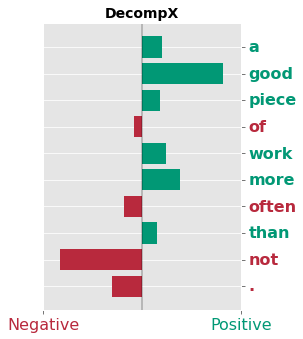

['a', 'good', 'piece', 'of', 'work', 'more', 'often', 'than', 'not', '.']


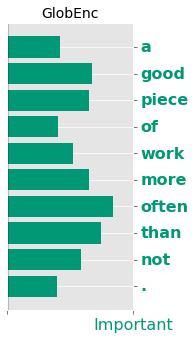

Configs:   0%|          | 0/5 [00:00<?, ?it/s]

['a', 'good', 'piece', 'of', 'work', 'more', 'often', 'than', 'not', '.']


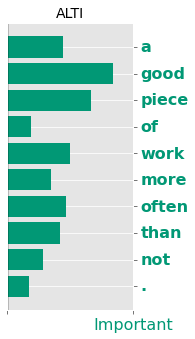

Configs:   0%|          | 0/5 [00:00<?, ?it/s]

['     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ']


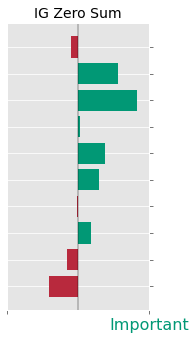

['     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ', '     ']


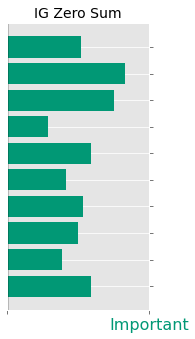

In [54]:
def plot_clf(tokens, logits, label_names, title="", file_name=None):
    print(tokens)
    if not "DecompX" in title:
        plt.figure(figsize=(3.0, 5))
    else:
        plt.figure(figsize=(4.5, 5))
    colors = ["#019875" if l else "#B8293D" for l in (logits >= 0)]
    plt.barh(range(len(tokens)), logits, color=colors)
    plt.axvline(0, color='black', ls='-', lw=2, alpha=0.2)
    plt.gca().invert_yaxis()
    
    max_limit = np.max(np.abs(logits)) + 0.2
    min_limit = -0.01 if np.min(logits) > 0 else -max_limit
    plt.xlim(min_limit, max_limit)
    plt.gca().set_xticks([min_limit, max_limit])
    plt.gca().set_xticklabels(label_names)
    plt.gca().set_yticks(range(len(tokens)))
    plt.gca().set_yticklabels(tokens)

    plt.gca().yaxis.tick_right()
    for xtick, color in zip(plt.gca().get_yticklabels(), colors):
        xtick.set_color(color)
        xtick.set_fontweight("bold")
        xtick.set_verticalalignment("center")
    #     xtick.set_horizontalalignment("left")
    #     xtick.set_x(-0.2)

    for xtick, color in zip(plt.gca().get_xticklabels(), ["#B8293D", "#019875"]):
        xtick.set_color(color)
    if not "DecompX" in title:
        plt.title(title, fontsize=14)
    else:
        plt.title(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    if file_name:
        plt.savefig(f"figs/{file_name}.pdf", bbox_inches='tight')
    plt.show()

# SST2
idx = 424  # 424
for dir_model_dataset_set in tqdm(MODEL_DATASET_SET, desc="Models_Dataset_Sets"):
    dir, model_checkpoint, task_name, set_of_data = dir_model_dataset_set
    for cfg_name in tqdm(GLOBENC_CONFIG_NAMES, desc="Configs"):
        file_name = f"[{task_name}]_[{set_of_data}]_[{'-'.join(model_checkpoint.split('/')[-2:])}]_[{cfg_name}]"
        try:
            df = pd.read_pickle(f"{dir}/{file_name}.pkl")
        except Exception as e:
            continue
        try:
            label0 = df.iloc[idx]["importance_last_layer_classifier"][:, 0]
            label1 = df.iloc[idx]["importance_last_layer_classifier"][:, 1]
            tokens = df.iloc[idx]["tokens"][1:-1]
            label1 = label1[1:-1]
            label1 = label1 / np.max(np.abs(label1))
            plot_clf(tokens, label1, ['Negative','Positive'], title="DecompX", file_name="example_sst2_our_method")
        except Exception as e:
            if "GlobEnc" in cfg_name:
                globenc = df.iloc[idx]["importance_last_layer_aggregated"][0, :][1:-1]
                globenc = globenc / np.max(globenc)
                tokens = df.iloc[idx]["tokens"][1:-1]
                plot_clf(tokens, globenc, ['','Important'], title="GlobEnc", file_name="example_sst2_globenc")
            elif "ALTI" in cfg_name:
                globenc = df.iloc[idx]["importance_last_layer_aggregated"][0, :][1:-1]
                globenc = globenc / np.max(globenc)
                tokens = df.iloc[idx]["tokens"][1:-1]
                plot_clf(tokens, globenc, ['','Important'], title="ALTI", file_name="example_sst2_alti")
            else:
                globenc = df.iloc[idx]["importance_last_layer_aggregated"][0, :][1:-1]
                globenc = globenc / np.max(globenc)
                tokens = df.iloc[idx]["tokens"][1:-1]
                plot_clf(tokens, globenc, ['','Important'], title="IG Zero Sum", file_name="example_sst2_igzerosum")

In [5]:
# qnli
idx = 3933
label0 = df.iloc[idx]["importance_last_layer_classifier"][:, 0]
label1 = df.iloc[idx]["importance_last_layer_classifier"][:, 1]

tokens = df.iloc[idx]["tokens"][1:-1]
plot_clf(tokens, label0[1:-1], ['Not Entailment','Entailment'])
print(GLOBENC_CONFIG_NAMES)

NameError: name 'df' is not defined

In [ ]:
pd.set_option('display.max_colwidth', None)
df[(df["label"] == 0) & (df["tokens"].str.len() < 22)][["tokens", "logits"]]

In [ ]:
label0